In [1]:
import sys
sys.path.append("..") # To get storm code

import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils import shuffle

from typing import List, Dict

In [2]:
# Internal imports
from src.db import StormDB

sdb = StormDB()

# Helper
Not everything exists in the codebase, helper functions that might need to be added in future version will be here

In [3]:
def get_tracks_from_artists(artists: List[str], start_date: str, end_date: str) -> List[str]:
    """
    Returns all tracks in database from a list of artists and a date range for releases.
    """
    
    albums = sdb.get_albums_from_artists_by_date(artists, start_date, end_date)
    tracks = np.unique(sdb.get_tracks_from_albums(albums)).tolist()
    
    return tracks

# Preparation
Retrieve data from a playlist. Each storm comes configured with a great_targets configuration component, indicating where the best songs from the storm runs have been stored. This will be the basis of the outputs of the prediction

In [4]:
storm_name = 'film_vg_instrumental_v2'
fields = {
    'explicit':0, 
    'last_updated':0, 
    'album_id':0,
    'audio_analysis':0,
    'audio_analysis_flag':0,
} # This returns eveything but these fields, see a sample below.

In [5]:
# First grab the targets. These will be 1s in the prediction
target_playlist = sdb.get_config('film_vg_instrumental_v2')['great_targets']
target_track_ids = sdb.get_loaded_playlist_tracks(target_playlist)
target_tracks = sdb.get_track_info(target_track_ids, fields=fields)

In [6]:
# Next we need to get a sample of tracks that are not 1s. For a first pass we will
# grab everything by the artists in the last 5 years. We will sample downstream

artists = []
[artists.extend(track['artists']) for track in target_tracks]

non_target_track_ids = get_tracks_from_artists(artists, start_date='2017-01-01', end_date='2023-01-01')
non_target_tracks = sdb.get_track_info(non_target_track_ids, fields=fields)

In [7]:
# unify into one dataframe
df = (
    pd.DataFrame.from_records(target_tracks+non_target_tracks)
    .drop_duplicates('_id')
    .set_index('_id')
)

df['target'] = 0
df.loc[df[df.index.isin(target_track_ids)].index, 'target'] = 1

# Modeling
We want to try and predict the songs that I like. Out of 25,676, only ~200 are 'great_targets', which is a <.5% discovery rate. 

In [8]:
# Create an even sample of tracks
sampled = shuffle(df.groupby('target').head(len(target_track_ids)), random_state=42)
sampled.target.value_counts()

0    233
1    191
Name: target, dtype: int64

In [9]:
feature_cols = [
    'duration_ms', 
    'acousticness',
    'danceability', 
    'energy', 
    'instrumentalness', 
    'key',
    'liveness', 
    'loudness', 
    'mode', 
    'speechiness', 
    'tempo',
    'time_signature', 
    'valence',
]

X_train, X_test, y_train, y_test = train_test_split(sampled[feature_cols], sampled['target'])

In [18]:
dt = tree.DecisionTreeClassifier(class_weight={0:.05, 1:.95}, max_depth=8).fit(X_train.fillna(.5), y_train)

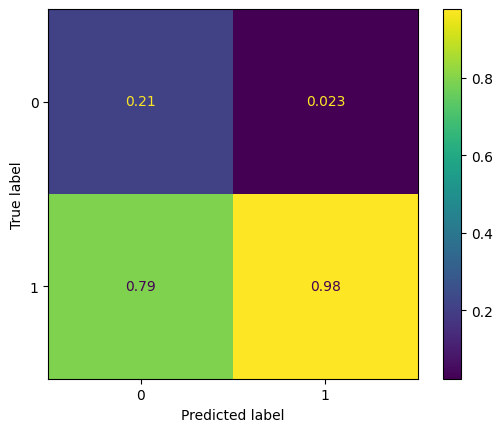

In [19]:
ConfusionMatrixDisplay(confusion_matrix(dt.predict(X_test.fillna(.5)), y_test, normalize='pred'), display_labels=dt.classes_).plot()

In [ ]:
dt.predict(X_test)

In [ ]:
y_test.values

In [ ]:
X_test